# MultiTaperConvNet
작성일:[2019-10-20]
작성자:Paul Kim

## 목표 
- Multitaper convolution network를 Build한다. 
- 새로운 모델로 성능을 측정해 본다.



### 1. Library Load

In [1]:
#%% 
import sys 
sys.path.append("C:/Users/win10/Workspace/kaggle.gongdeok/iceberg_week1/paul_temp")

import numpy as np

import pandas as pd

from scipy import signal
from random import sample
from iceberg_data import load_data, to_numpy
import models

import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Tensorflow Settings 
tf.executing_eagerly()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: tf.config.experimental.set_memory_growth(gpus[0], True)

###  2. Define Helper function 


In [2]:
def preprocessing(batch_x):

    normalize  = lambda x : (x+50)/ (40+50)

    preprocess = lambda x :  np.transpose(np.array([
            normalize(x[:,:,0]), 
            normalize(x[:,:,1])]), [1,2,0])   

    return np.array([ preprocess(x) for x in batch_x])


def train_gen(X, Y, batch_size= 32, epochs=200):

    for _ in range(epochs*2):
        datagen = ImageDataGenerator(
                horizontal_flip = True, 
                vertical_flip   = True, 
                rotation_range  = 15,
                fill_mode       = 'nearest')

        datagen.fit(X)

        for x, y in datagen.flow(X, Y, batch_size=32):

            x = preprocessing(x)

            yield x, y 

def valid_gen(X, Y, batch_size= 32, epochs=200):

    for _ in range(epochs*2):
        for i in range(len(X)//batch_size):

            x = X[i*batch_size:(i+1)*batch_size]
            x = preprocessing(x)
            y = Y[i*batch_size:(i+1)*batch_size]

            yield x, y 

### 3. Data load & Split train valid set 

In [3]:
data = load_data()
X, Y = to_numpy(data)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.25)

### 4. Model build & training

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops.losses.losses_impl import log_loss

"Model Training"
check_pointer = ModelCheckpoint(
    filepath='./models/MultiTaperConvNet_001.h5',
    monitor='val_log_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    
    
    save_freq='epoch',)

model = models.MultiTaperConvNet()
model.build((32,75,75,2))
model.compile(
    optimizer=Adam(lr=10e-4),
    loss='binary_crossentropy',
    metrics=[log_loss],
)

model.summary()

Model: "multi_taper_conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  40192     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  422528    
_________________________________________________________________
sequential_2 (Sequential)    multiple                  950528    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  1689728   
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
sequential_4 (Sequential)    multiple                  14254592  
_________________________________________________________________
sequential_5 (Sequential)    multiple         

In [5]:
epochs = 500
history = model.fit_generator(
    generator        = train_gen(X_train, y_train, batch_size=32, epochs=epochs),
    steps_per_epoch  = len(X_train) // 32, 
    validation_data  = valid_gen(
        X_valid, y_valid, batch_size=32, epochs=epochs),
    validation_steps = len(X_valid)//32, 
    epochs=epochs, 
    callbacks=[check_pointer])

Epoch 1/500


c:\users\win10\envs\tf2.0\lib\site-packages\keras_preprocessing\image\image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1203, 75, 75, 2) (2 channels).
  ' channels).')
c:\users\win10\envs\tf2.0\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1203, 75, 75, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


37/37 [==============================] - 8s 208ms/step - loss: 0.7737 - log_loss: 0.9417 - val_loss: 0.6926 - val_log_loss: 0.6926
Epoch 2/500
37/37 [==============================] - 4s 98ms/step - loss: 0.6929 - log_loss: 0.6924 - val_loss: 0.6923 - val_log_loss: 0.6923
Epoch 3/500
37/37 [==============================] - 3s 71ms/step - loss: 0.6935 - log_loss: 0.6938 - val_loss: 0.6922 - val_log_loss: 0.6922
Epoch 4/500
37/37 [==============================] - 2s 67ms/step - loss: 0.6904 - log_loss: 0.6884 - val_loss: 0.6935 - val_log_loss: 0.6935
Epoch 5/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6920 - log_loss: 0.6934 - val_loss: 0.6884 - val_log_loss: 0.6884
Epoch 6/500
37/37 [==============================] - 2s 66ms/step - loss: 0.6949 - log_loss: 0.7017 - val_loss: 0.6907 - val_log_loss: 0.6907
Epoch 7/500
37/37 [==============================] - 3s 69ms/step - loss: 0.6897 - log_loss: 0.6915 - val_loss: 0.6885 - val_log_loss: 0.6885
Epoch 8/500
37/37

37/37 [==============================] - 3s 68ms/step - loss: 0.3695 - log_loss: 0.3709 - val_loss: 0.3061 - val_log_loss: 0.3061
Epoch 59/500
37/37 [==============================] - 3s 69ms/step - loss: 0.3357 - log_loss: 0.3475 - val_loss: 0.3128 - val_log_loss: 0.3128
Epoch 60/500
37/37 [==============================] - 3s 69ms/step - loss: 0.3349 - log_loss: 0.3392 - val_loss: 0.3069 - val_log_loss: 0.3069
Epoch 61/500
37/37 [==============================] - 3s 69ms/step - loss: 0.3414 - log_loss: 0.3641 - val_loss: 0.3662 - val_log_loss: 0.3662
Epoch 62/500
37/37 [==============================] - 3s 70ms/step - loss: 0.3222 - log_loss: 0.3053 - val_loss: 0.4055 - val_log_loss: 0.4055
Epoch 63/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3322 - log_loss: 0.3559 - val_loss: 0.2987 - val_log_loss: 0.2987
Epoch 64/500
37/37 [==============================] - 3s 69ms/step - loss: 0.3095 - log_loss: 0.2884 - val_loss: 0.3056 - val_log_loss: 0.3056
Epoch 65/500

37/37 [==============================] - 3s 70ms/step - loss: 0.2703 - log_loss: 0.2694 - val_loss: 0.2690 - val_log_loss: 0.2690
Epoch 116/500
37/37 [==============================] - 3s 69ms/step - loss: 0.2852 - log_loss: 0.2961 - val_loss: 0.3440 - val_log_loss: 0.3440
Epoch 117/500
37/37 [==============================] - 3s 69ms/step - loss: 0.2803 - log_loss: 0.2884 - val_loss: 0.4510 - val_log_loss: 0.4510
Epoch 118/500
37/37 [==============================] - 3s 69ms/step - loss: 0.2875 - log_loss: 0.2946 - val_loss: 0.3159 - val_log_loss: 0.3159
Epoch 119/500
37/37 [==============================] - 3s 69ms/step - loss: 0.2719 - log_loss: 0.2751 - val_loss: 0.3086 - val_log_loss: 0.3086
Epoch 120/500
37/37 [==============================] - 3s 69ms/step - loss: 0.2717 - log_loss: 0.2667 - val_loss: 0.3201 - val_log_loss: 0.3201
Epoch 121/500
37/37 [==============================] - 3s 70ms/step - loss: 0.2789 - log_loss: 0.2593 - val_loss: 0.3477 - val_log_loss: 0.3477
Epoch 

Epoch 172/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2133 - log_loss: 0.1960 - val_loss: 0.5283 - val_log_loss: 0.5303
Epoch 173/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2888 - log_loss: 0.2774 - val_loss: 0.4022 - val_log_loss: 0.4022
Epoch 174/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2456 - log_loss: 0.2345 - val_loss: 0.3204 - val_log_loss: 0.3204
Epoch 175/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2156 - log_loss: 0.2013 - val_loss: 0.3361 - val_log_loss: 0.3361
Epoch 176/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2666 - log_loss: 0.2446 - val_loss: 0.3457 - val_log_loss: 0.3457
Epoch 177/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2412 - log_loss: 0.2644 - val_loss: 0.3764 - val_log_loss: 0.3764
Epoch 178/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2418 - log_loss: 0.2368 - val_loss: 0.4972 - val_log_loss:

Epoch 229/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2249 - log_loss: 0.2048 - val_loss: 0.3523 - val_log_loss: 0.3523
Epoch 230/500
37/37 [==============================] - 3s 68ms/step - loss: 0.2008 - log_loss: 0.2082 - val_loss: 0.3080 - val_log_loss: 0.3080
Epoch 231/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2254 - log_loss: 0.2031 - val_loss: 0.3837 - val_log_loss: 0.3837
Epoch 232/500
37/37 [==============================] - 3s 69ms/step - loss: 0.1960 - log_loss: 0.1976 - val_loss: 0.3685 - val_log_loss: 0.3685
Epoch 233/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2207 - log_loss: 0.2060 - val_loss: 0.3351 - val_log_loss: 0.3351
Epoch 234/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1892 - log_loss: 0.2037 - val_loss: 0.2956 - val_log_loss: 0.2956
Epoch 235/500
37/37 [==============================] - 2s 66ms/step - loss: 0.2202 - log_loss: 0.2041 - val_loss: 0.3163 - val_log_loss:

Epoch 286/500
37/37 [==============================] - 2s 67ms/step - loss: 0.2120 - log_loss: 0.1899 - val_loss: 0.4024 - val_log_loss: 0.4024
Epoch 287/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1676 - log_loss: 0.1787 - val_loss: 0.4377 - val_log_loss: 0.4377
Epoch 288/500
37/37 [==============================] - 2s 68ms/step - loss: 0.1884 - log_loss: 0.1998 - val_loss: 0.3944 - val_log_loss: 0.3944
Epoch 289/500
37/37 [==============================] - 3s 69ms/step - loss: 0.1916 - log_loss: 0.1688 - val_loss: 0.4677 - val_log_loss: 0.4677
Epoch 290/500
37/37 [==============================] - 3s 70ms/step - loss: 0.1997 - log_loss: 0.2173 - val_loss: 0.3968 - val_log_loss: 0.3968
Epoch 291/500
37/37 [==============================] - 3s 68ms/step - loss: 0.1628 - log_loss: 0.1387 - val_loss: 0.3122 - val_log_loss: 0.3122
Epoch 292/500
37/37 [==============================] - 2s 66ms/step - loss: 0.2133 - log_loss: 0.2380 - val_loss: 0.3577 - val_log_loss:

37/37 [==============================] - 2s 67ms/step - loss: 0.1637 - log_loss: 0.1682 - val_loss: 0.3122 - val_log_loss: 0.3122
Epoch 343/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1474 - log_loss: 0.1723 - val_loss: 0.3560 - val_log_loss: 0.3560
Epoch 344/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1453 - log_loss: 0.1481 - val_loss: 0.3332 - val_log_loss: 0.3332
Epoch 345/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1471 - log_loss: 0.1585 - val_loss: 0.3710 - val_log_loss: 0.3710
Epoch 346/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1397 - log_loss: 0.1386 - val_loss: 0.4311 - val_log_loss: 0.4311
Epoch 347/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1655 - log_loss: 0.1700 - val_loss: 0.3403 - val_log_loss: 0.3403
Epoch 348/500
37/37 [==============================] - 2s 66ms/step - loss: 0.1551 - log_loss: 0.1552 - val_loss: 0.4625 - val_log_loss: 0.4646
Epoch 

37/37 [==============================] - 2s 68ms/step - loss: 0.1444 - log_loss: 0.1494 - val_loss: 0.3588 - val_log_loss: 0.3588
Epoch 399/500
37/37 [==============================] - 3s 68ms/step - loss: 0.1343 - log_loss: 0.1519 - val_loss: 0.3629 - val_log_loss: 0.3629s - loss: 0.1383 - log_loss: 
Epoch 400/500
37/37 [==============================] - 3s 68ms/step - loss: 0.1494 - log_loss: 0.1667 - val_loss: 0.4023 - val_log_loss: 0.4023
Epoch 401/500
37/37 [==============================] - 3s 68ms/step - loss: 0.1375 - log_loss: 0.1512 - val_loss: 0.3613 - val_log_loss: 0.3613
Epoch 402/500
37/37 [==============================] - 3s 68ms/step - loss: 0.1564 - log_loss: 0.1537 - val_loss: 0.4165 - val_log_loss: 0.4165
Epoch 403/500
37/37 [==============================] - 3s 69ms/step - loss: 0.1422 - log_loss: 0.1785 - val_loss: 0.3565 - val_log_loss: 0.3565
Epoch 404/500
37/37 [==============================] - 3s 68ms/step - loss: 0.1254 - log_loss: 0.1009 - val_loss: 0.5065 

Epoch 455/500
37/37 [==============================] - 3s 72ms/step - loss: 0.1081 - log_loss: 0.0998 - val_loss: 0.3648 - val_log_loss: 0.3648
Epoch 456/500
37/37 [==============================] - 2s 67ms/step - loss: 0.1675 - log_loss: 0.1917 - val_loss: 0.4979 - val_log_loss: 0.4979
Epoch 457/500
37/37 [==============================] - 3s 72ms/step - loss: 0.1364 - log_loss: 0.1644 - val_loss: 0.5074 - val_log_loss: 0.5074
Epoch 458/500
37/37 [==============================] - 3s 73ms/step - loss: 0.1197 - log_loss: 0.1061 - val_loss: 0.4429 - val_log_loss: 0.4429
Epoch 459/500
37/37 [==============================] - 3s 74ms/step - loss: 0.1257 - log_loss: 0.1231 - val_loss: 0.3826 - val_log_loss: 0.3826
Epoch 460/500
37/37 [==============================] - 3s 76ms/step - loss: 0.1159 - log_loss: 0.1176 - val_loss: 0.5561 - val_log_loss: 0.5570
Epoch 461/500
37/37 [==============================] - 3s 75ms/step - loss: 0.1370 - log_loss: 0.1478 - val_loss: 0.3913 - val_log_loss:

### 5. plot results(history)

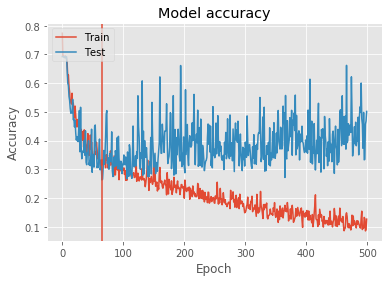

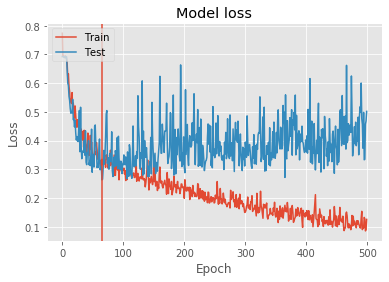

In [6]:
best_epoch = history.history['val_log_loss'].index(
    np.min((history.history['val_log_loss'])))
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axvline(x=best_epoch)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['log_loss'])
plt.plot(history.history['val_log_loss'])
plt.axvline(x=best_epoch)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 6. evaluate model

In [9]:
def preprocessing_old(batch_x):

    normalize  = lambda x : (x+50)/ (40+50)

    preprocess = lambda x :  np.transpose(np.array([
            normalize(x[:,:,0]), 
            normalize(x[:,:,1])]), [1,2,0])   

    return np.array([ preprocess(x) for x in batch_x])

In [11]:
import tensorflow as tf 
# val_dataset = tf.data.Dataset.from_tensor_slices((preprocessing(X_valid), y_valid)).batch(401)
# model.load_weights('./models/simple_conv_net.h5')
# res_loss, res_log_loss = model.evaluate(val_dataset)
# print(f"기존 Dataset")
# print(f"Loss     : {res_loss:0.5f}\nLog loss : {res_log_loss:0.5f}")

val_dataset = tf.data.Dataset.from_tensor_slices((preprocessing(X_valid), y_valid)).batch(401)
model.load_weights('./models/MultiTaperConvNet_001.h5')
res_loss, res_log_loss = model.evaluate(val_dataset)
print(f"신규 Dataset")
print(f"Loss     : {res_loss:0.5f}\nLog loss : {res_log_loss:0.5f}")

1/1 [==============================] - 2s 2s/step - loss: 0.2669 - log_loss: 0.2669
신규 Dataset
Loss     : 0.26693
Log loss : 0.26693


### 7. Generate submission file

In [12]:
path_test = "C:/Users/win10/Workspace/kaggle.dataset/statoil-iceberg-classifier-challenge/test.json"
test = pd.read_json(path_test)
test['inc_angle'] = pd.to_numeric(test['inc_angle'],errors='coerce')

"Raw data to numpy"
band_1 = test['band_1'].apply(lambda x: np.reshape(x, newshape=(75,75)))
band_2 = test['band_2'].apply(lambda x: np.reshape(x, newshape=(75,75)))

test_X = np.array([
    np.transpose(np.array([b1,b2]),[1,2,0]) 
    for b1, b2 in zip(band_1, band_2)], dtype=np.float32)

test_X = preprocessing(test_X)

In [13]:
"Build Dataset"
dataset = tf.data.Dataset.from_tensor_slices(test_X).batch(32)
"Model inferencing & save results "
pred_y = model.predict(dataset)
test['is_iceberg'] = pred_y
test[['id','is_iceberg']].to_csv('./submissions/MultiTaperConvNet_001.csv', index=False)

### 7. Conclusion
MultiTaperConvNet은 성능이 더 좋지 않았음

![submission](./images/submission_20191020_001.PNG)